In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("all_results_10-20-2024.csv")

In [4]:
df.columns

Index(['join_key', 'experiment', 'experiment_date', 'model.loss',
       'model.model_architecture', 'model.pos_weight', 'model.alpha',
       'model.lr', 'dataloader.batch_size', 'training.max_epochs',
       'metrics.FPR_no_plume', 'metrics.frac_total_easy',
       'metrics.precision_easy', 'metrics.recall_easy', 'metrics.f1score_easy',
       'metrics.iou_easy', 'metrics.accuracy_easy', 'metrics.cohen_kappa_easy',
       'metrics.balanced_accuracy_easy', 'metrics.precision_hard',
       'metrics.recall_hard', 'metrics.f1score_hard', 'metrics.iou_hard',
       'metrics.accuracy_hard', 'metrics.cohen_kappa_hard',
       'metrics.balanced_accuracy_hard', 'metrics.frac_total_hard',
       'metrics.precision', 'metrics.recall', 'metrics.f1score', 'metrics.iou',
       'metrics.accuracy', 'metrics.cohen_kappa', 'metrics.balanced_accuracy'],
      dtype='object')

### Best performance per model


In [5]:
df.groupby("model.model_architecture").max()[
    [
        "metrics.precision",
        "metrics.f1score",
        "metrics.iou",
        "metrics.recall",
    ]
]

,metrics.precision,metrics.f1score,metrics.iou,metrics.recall
model.model_architecture,,,,
deeplabv3_resnet50,0.714871,0.517388,0.348971,0.832491
fcn_resnet50,0.611002,0.659452,0.491927,0.870607
segformer,0.433647,0.510970,0.343156,0.969075


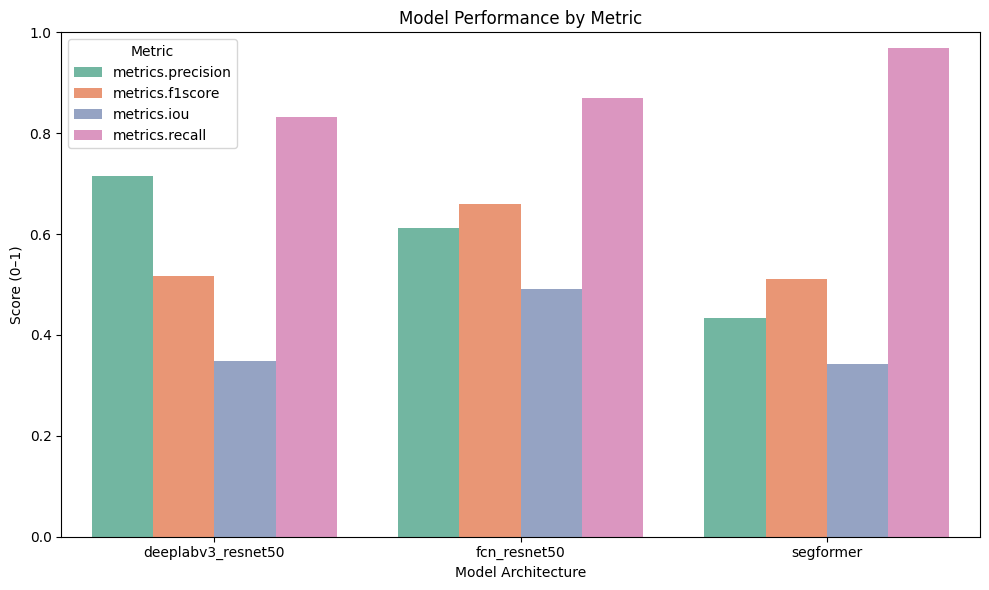

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate your metrics
agg = df.groupby("model.model_architecture").max()[
    ["metrics.precision", "metrics.f1score", "metrics.iou", "metrics.recall"]
].reset_index()

# Melt for long-form plotting
agg_melted = agg.melt(
    id_vars="model.model_architecture",
    var_name="Metric",
    value_name="Score"
)

# Plot grouped bar chart, colored by metric
plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg_melted,
    x="model.model_architecture",
    y="Score",
    hue="Metric",
    palette="Set2"
)

plt.title("Model Performance by Metric")
plt.xlabel("Model Architecture")
plt.ylabel("Score (0–1)")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


In [7]:
architecture_mapping = {
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "fcn_resnet50": "FCN (ResNet-50)",
    "segformer": "SegFormer (B0)",
    "unet_mini": "U-Net (Mini)"
}


# --- Load ---
df = pd.read_csv("all_results_10-20-2024.csv")
df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)


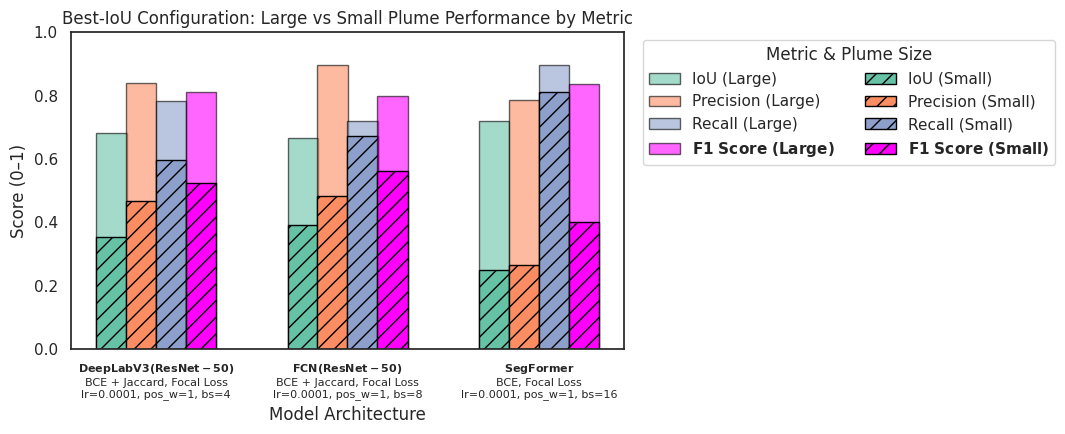

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Architecture display names ---
architecture_mapping = {
    "fcn_resnet50": "FCN (ResNet-50)",
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "segformer": "SegFormer",
}

loss_mapping = {
    "BCEWithLogitsLoss": "BCE, Focal Loss",
    "JaccardLoss": "Jaccard (IoU), Focal Loss",
    "HybridBCEJaccardLoss": "BCE + Jaccard, Focal Loss",
}


# --- Load ---
df = pd.read_csv("all_results_10-20-2024.csv")
df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)
df["model.loss_display"] = df["model.loss"].map(loss_mapping)

# --- Find best-IoU run per architecture for Easy/Hard ---
idx_easy = df.groupby("model.model_architecture")["metrics.iou_easy"].idxmax()
idx_hard = df.groupby("model.model_architecture")["metrics.iou_hard"].idxmax()
best_iou_easy_runs = df.loc[idx_easy].reset_index(drop=True)
best_iou_hard_runs = df.loc[idx_hard].reset_index(drop=True)

# --- Extract metric data ---
easy = best_iou_easy_runs[
    ["model.model_architecture_display", "metrics.iou_easy", "metrics.precision_easy", 
      "metrics.recall_easy", "metrics.f1score_easy"]
].copy()
hard = best_iou_hard_runs[
    ["model.model_architecture_display", "metrics.iou_hard", "metrics.precision_hard",
     "metrics.recall_hard", "metrics.f1score_hard"]
].copy()

easy
hard

# --- Melt and combine ---
easy_melted = easy.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
easy_melted["Difficulty"] = "Large"

hard_melted = hard.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
hard_melted["Difficulty"] = "Small"

hard_melted

combined = pd.concat([easy_melted, hard_melted], ignore_index=True)
metric_mapping = {
    "metrics.iou_easy": "IoU",
    "metrics.iou_hard": "IoU",
    "metrics.precision_easy": "Precision",
    "metrics.precision_hard": "Precision",
    "metrics.recall_easy": "Recall",
    "metrics.recall_hard": "Recall",
    "metrics.f1score_easy": "F1 Score",
    "metrics.f1score_hard": "F1 Score",
}# --- Build training configuration table ---
config_cols = [
    "model.model_architecture", "model.model_architecture_display",
    "model.loss", "model.lr", "model.pos_weight",
    "model.alpha", "dataloader.batch_size", "training.max_epochs"
]

combined["Metric"] = combined["Metric"].map(metric_mapping).fillna(combined["Metric"])

configs = pd.concat([
    best_iou_easy_runs[config_cols].assign(Difficulty="Large"),
    best_iou_hard_runs[config_cols].assign(Difficulty="Small")
])
configs = configs.sort_values(["Difficulty", "model.model_architecture_display"]).reset_index(drop=True)

# --- Plot ---
sns.set_theme(style="white")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 4.5))

num_metrics = len(combined["Metric"].unique())
bar_width = 0.12  # manually control bar width
spacing = 1.3     # tweak this to control gap between bars

for i, metric in enumerate(combined["Metric"].unique()):
    subset = combined[combined["Metric"] == metric]
    x_positions = np.arange(len(subset["model.model_architecture_display"].unique()))
    width = 0.35

    for difficulty in ["Large", "Small"]:
        vals = subset[subset["Difficulty"] == difficulty]["Score"].values

        display_metric = (
            rf"$\bf{{{metric.replace(' ', r'\ ')}}}\ ({difficulty})$"
            if metric == "F1 Score"
            else f"{metric} ({difficulty})"
        )

        color = "#FF00FF" if metric == "F1 Score" else palette[i]

        offset = (i - (num_metrics - 1) / 2) * bar_width * spacing
        ax.bar(
            x_positions + offset,
            vals,
            width=width / 2.2,
            color=color,
            alpha=0.6 if difficulty == "Large" else 1.0,
            hatch="//" if difficulty == "Small" else "",
            edgecolor="black",
            label=display_metric,
        )
labels = []

for _, row in best_iou_easy_runs.iterrows():
    arch = row["model.model_architecture_display"]
    loss = row["model.loss_display"]
    lr = row["model.lr"]
    pw = row["model.pos_weight"]
    bs = int(row["dataloader.batch_size"])
    label = rf"$\bf{{{arch}}}$" + f"\n{loss}\nlr={lr}, pos_w={pw}, bs={bs}"
    labels.append(label)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=8)
fig.subplots_adjust(bottom=0.35)

ax.set_ylim(0, 1)
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Model Architecture")
ax.set_title("Best-IoU Configuration: Large vs Small Plume Performance by Metric")

# --- Legend ---
handles, labels = ax.get_legend_handles_labels()
ncol = 2
order = np.arange(len(labels))
order = order.reshape(-1, ncol).T.flatten()

ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    ncol=ncol,
    title="Metric & Plume Size",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
frameon=True,
)

plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.savefig("best_iou_with_configs.png", bbox_inches="tight", dpi=1200)
plt.show()


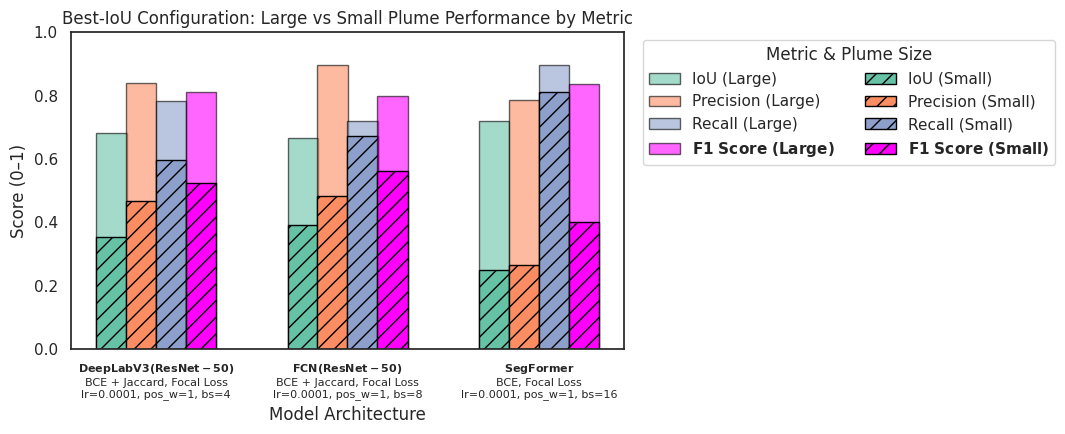

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Architecture display names ---
architecture_mapping = {
    "fcn_resnet50": "FCN (ResNet-50)",
    "deeplabv3_resnet50": "DeepLabV3 (ResNet-50)",
    "segformer": "SegFormer",
}

loss_mapping = {
    "BCEWithLogitsLoss": "BCE, Focal Loss",
    "JaccardLoss": "Jaccard (IoU), Focal Loss",
    "HybridBCEJaccardLoss": "BCE + Jaccard, Focal Loss",
}


# --- Load ---
df = pd.read_csv("all_results_10-20-2024.csv")
df["model.model_architecture_display"] = df["model.model_architecture"].map(architecture_mapping)
df["model.loss_display"] = df["model.loss"].map(loss_mapping)

# --- Find best-IoU run per architecture for Easy/Hard ---
idx_easy = df.groupby("model.model_architecture")["metrics.iou_easy"].idxmax()
idx_hard = df.groupby("model.model_architecture")["metrics.iou_hard"].idxmax()
best_iou_easy_runs = df.loc[idx_easy].reset_index(drop=True)
best_iou_hard_runs = df.loc[idx_hard].reset_index(drop=True)

# --- Extract metric data ---
easy = best_iou_easy_runs[
    ["model.model_architecture_display", "metrics.iou_easy", "metrics.precision_easy", 
      "metrics.recall_easy", "metrics.f1score_easy"]
].copy()
hard = best_iou_hard_runs[
    ["model.model_architecture_display", "metrics.iou_hard", "metrics.precision_hard",
     "metrics.recall_hard", "metrics.f1score_hard"]
].copy()

easy
hard

# --- Melt and combine ---
easy_melted = easy.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
easy_melted["Difficulty"] = "Large"

hard_melted = hard.melt(id_vars="model.model_architecture_display", var_name="Metric", value_name="Score")
hard_melted["Difficulty"] = "Small"

hard_melted

combined = pd.concat([easy_melted, hard_melted], ignore_index=True)
metric_mapping = {
    "metrics.iou_easy": "IoU",
    "metrics.iou_hard": "IoU",
    "metrics.precision_easy": "Precision",
    "metrics.precision_hard": "Precision",
    "metrics.recall_easy": "Recall",
    "metrics.recall_hard": "Recall",
    "metrics.f1score_easy": "F1 Score",
    "metrics.f1score_hard": "F1 Score",
}# --- Build training configuration table ---
config_cols = [
    "model.model_architecture", "model.model_architecture_display",
    "model.loss", "model.lr", "model.pos_weight",
    "model.alpha", "dataloader.batch_size", "training.max_epochs"
]

combined["Metric"] = combined["Metric"].map(metric_mapping).fillna(combined["Metric"])

configs = pd.concat([
    best_iou_easy_runs[config_cols].assign(Difficulty="Large"),
    best_iou_hard_runs[config_cols].assign(Difficulty="Small")
])
configs = configs.sort_values(["Difficulty", "model.model_architecture_display"]).reset_index(drop=True)

# --- Plot ---
sns.set_theme(style="white")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 4.5))

num_metrics = len(combined["Metric"].unique())
bar_width = 0.12  # manually control bar width
spacing = 1.3     # tweak this to control gap between bars

for i, metric in enumerate(combined["Metric"].unique()):
    subset = combined[combined["Metric"] == metric]
    x_positions = np.arange(len(subset["model.model_architecture_display"].unique()))
    width = 0.35

    for difficulty in ["Large", "Small"]:
        vals = subset[subset["Difficulty"] == difficulty]["Score"].values

        display_metric = (
            rf"$\bf{{{metric.replace(' ', r'\ ')}}}\ ({difficulty})$"
            if metric == "F1 Score"
            else f"{metric} ({difficulty})"
        )

        color = "#FF00FF" if metric == "F1 Score" else palette[i]

        offset = (i - (num_metrics - 1) / 2) * bar_width * spacing
        ax.bar(
            x_positions + offset,
            vals,
            width=width / 2.2,
            color=color,
            alpha=0.6 if difficulty == "Large" else 1.0,
            hatch="//" if difficulty == "Small" else "",
            edgecolor="black",
            label=display_metric,
        )
labels = []

for _, row in best_iou_easy_runs.iterrows():
    arch = row["model.model_architecture_display"]
    loss = row["model.loss_display"]
    lr = row["model.lr"]
    pw = row["model.pos_weight"]
    bs = int(row["dataloader.batch_size"])
    label = rf"$\bf{{{arch}}}$" + f"\n{loss}\nlr={lr}, pos_w={pw}, bs={bs}"
    labels.append(label)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=8)
fig.subplots_adjust(bottom=0.35)

ax.set_ylim(0, 1)
ax.set_ylabel("Score (0–1)")
ax.set_xlabel("Model Architecture")
ax.set_title("Best-IoU Configuration: Large vs Small Plume Performance by Metric")

# --- Legend ---
handles, labels = ax.get_legend_handles_labels()
ncol = 2
order = np.arange(len(labels))
order = order.reshape(-1, ncol).T.flatten()

ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    ncol=ncol,
    title="Metric & Plume Size",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
frameon=True,
)

plt.tight_layout(rect=[0, 0, 0.78, 1])
plt.savefig("best_iou_with_configs.png", bbox_inches="tight", dpi=1200)
plt.show()


In [10]:
# Best row per architecture for Easy / Hard
idx_easy = df.groupby("model.model_architecture")["metrics.iou_easy"].idxmax()
idx_hard = df.groupby("model.model_architecture")["metrics.iou_hard"].idxmax()

best_easy = df.loc[idx_easy].copy().assign(Difficulty="Easy")
best_hard = df.loc[idx_hard].copy().assign(Difficulty="Hard")

# Columns to show (tweak as you like)
config_cols = [
    "Difficulty",
    "model.model_architecture",
    "model.loss",
    "model.pos_weight",
    "model.alpha",
    "model.lr",
    "dataloader.batch_size",
    "training.max_epochs",
    "experiment",
    "experiment_date",
    "join_key",
    # key metrics—keep both IoUs so you can compare
    "metrics.iou_easy",
    "metrics.iou_hard",
    "metrics.f1score_easy",
    "metrics.f1score_hard",
    "metrics.precision_easy",
    "metrics.recall_easy",
    "metrics.precision_hard",
    "metrics.recall_hard",
]

# Display each table
easy_configs = best_easy[config_cols].sort_values("model.model_architecture").reset_index(drop=True)
hard_configs = best_hard[config_cols].sort_values("model.model_architecture").reset_index(drop=True)

# Combined table (one row per arch per difficulty)
combined = (
    pd.concat([easy_configs, hard_configs], ignore_index=True)
      .sort_values(["model.model_architecture", "Difficulty"])
      .reset_index(drop=True)
)

# If you’re in a notebook:
from IPython.display import display
display(easy_configs.style.set_caption("Best IoU (Easy) — Configuration Details"))
display(hard_configs.style.set_caption("Best IoU (Hard) — Configuration Details"))


,Difficulty,model.model_architecture,model.loss,model.pos_weight,model.alpha,model.lr,dataloader.batch_size,training.max_epochs,experiment,experiment_date,join_key,metrics.iou_easy,metrics.iou_hard,metrics.f1score_easy,metrics.f1score_hard,metrics.precision_easy,metrics.recall_easy,metrics.precision_hard,metrics.recall_hard
0,Easy,deeplabv3_resnet50,HybridBCEJaccardLoss,1,0.500000,0.000100,4,150,2025-10-13_05-48-42_1535041,2025-10-13_05-48-42_1535041,2025-10-13-05-48-42-1535041,0.683143,0.272305,0.811746,0.428050,0.840845,0.784594,0.310810,0.687307
1,Easy,fcn_resnet50,HybridBCEJaccardLoss,1,0.500000,0.000100,8,150,2025-10-15_05-47-28_1535064,2025-10-15_05-47-28_1535064,2025-10-15-05-47-28-1535064,0.666268,0.264280,0.799713,0.418073,0.898296,0.720629,0.309694,0.643141
2,Easy,segformer,BCEWithLogitsLoss,1,0.500000,0.000100,16,150,2025-10-12_14-30-17_1530470,2025-10-12_14-30-17_1530470,2025-10-12-14-30-17-1530470,0.721239,0.224031,0.838047,0.366055,0.787390,0.895670,0.238829,0.783353


,Difficulty,model.model_architecture,model.loss,model.pos_weight,model.alpha,model.lr,dataloader.batch_size,training.max_epochs,experiment,experiment_date,join_key,metrics.iou_easy,metrics.iou_hard,metrics.f1score_easy,metrics.f1score_hard,metrics.precision_easy,metrics.recall_easy,metrics.precision_hard,metrics.recall_hard
0,Hard,deeplabv3_resnet50,HybridBCEJaccardLoss,5,0.500000,0.000100,8,150,2025-10-13_05-48-42_1535046,2025-10-13_05-48-42_1535046,2025-10-13-05-48-42-1535046,0.475257,0.354992,0.644304,0.523977,0.850810,0.518463,0.466590,0.597458
1,Hard,fcn_resnet50,BCEWithLogitsLoss,1,0.500000,0.000100,16,150,2025-10-14_13-26-11_1535053,2025-10-14_13-26-11_1535053,2025-10-14-13-26-11-1535053,0.654947,0.391974,0.791502,0.563191,0.868424,0.727098,0.484188,0.673004
2,Hard,segformer,BCEWithLogitsLoss,1,0.500000,0.000100,4,150,2025-10-12_14-30-07_1530468,2025-10-12_14-30-07_1530468,2025-10-12-14-30-07-1530468,0.706309,0.251083,0.827880,0.401385,0.779457,0.882718,0.266731,0.810601


In [11]:
# Best row per architecture for Overall IoU
idx_overall = df.groupby("model.model_architecture")["metrics.iou"].idxmax()
best_overall = df.loc[idx_overall].copy().assign(Difficulty="Overall")

# Columns to show
config_cols = [
    "Difficulty",
    "model.model_architecture",
    "model.loss",
    "model.pos_weight",
    "model.alpha",
    "model.lr",
    "dataloader.batch_size",
    "training.max_epochs",
    "experiment",
    "experiment_date",
    "join_key",
    "metrics.iou",        # overall IoU (added)
    "metrics.iou_easy",
    "metrics.iou_hard",
    "metrics.f1score_easy",
    "metrics.f1score_hard",
    "metrics.precision_easy",
    "metrics.recall_easy",
    "metrics.precision_hard",
    "metrics.recall_hard",
]

# Keep only columns that exist to avoid KeyError
config_cols = [c for c in config_cols if c in best_overall.columns]

# Display table
best_configs = (
    best_overall[config_cols]
    .sort_values("model.model_architecture")
    .reset_index(drop=True)
)

# If you’re in a notebook:
from IPython.display import display
display(best_configs.style.set_caption("Best IoU (Overall) — Configuration Details"))


,Difficulty,model.model_architecture,model.loss,model.pos_weight,model.alpha,model.lr,dataloader.batch_size,training.max_epochs,experiment,experiment_date,join_key,metrics.iou,metrics.iou_easy,metrics.iou_hard,metrics.f1score_easy,metrics.f1score_hard,metrics.precision_easy,metrics.recall_easy,metrics.precision_hard,metrics.recall_hard
0,Overall,deeplabv3_resnet50,HybridBCEJaccardLoss,5,0.500000,0.000100,4,150,2025-10-13_05-48-42_1535045,2025-10-13_05-48-42_1535045,2025-10-13-05-48-42-1535045,0.348971,0.570739,0.123297,0.726714,0.219527,0.858925,0.629775,0.204363,0.237121
1,Overall,fcn_resnet50,BCEWithLogitsLoss,1,0.500000,0.000100,16,150,2025-10-14_13-26-11_1535053,2025-10-14_13-26-11_1535053,2025-10-14-13-26-11-1535053,0.491927,0.654947,0.391974,0.791502,0.563191,0.868424,0.727098,0.484188,0.673004
2,Overall,segformer,JaccardLoss,1,0.500000,0.000100,16,150,2025-10-15_05-47-28_1530480,2025-10-15_05-47-28_1530480,2025-10-15-05-47-28-1530480,0.343156,0.624782,0.154588,0.769066,0.267780,0.854925,0.698878,0.232946,0.314863
